In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization, Conv2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [3]:
#1. Dataset Preparation
def load_data():
    (x_train, _), (_, _) = fashion_mnist.load_data()
    x_train = x_train / 255.0
    x_train = np.expand_dims(x_train, axis=-1)
    return x_train

In [4]:
x_train = load_data()
print(f"Dataset shape: {x_train.shape}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset shape: (60000, 28, 28, 1)


In [5]:
#2.Defining GAN with a Generator as asked in the exam
def build_generator(latent_dim):
    model = Sequential([
        Dense(7 * 7 * 128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 128)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, (7, 7), activation='sigmoid', padding='same'),
    ])
    return model

In [6]:
#3.Defining GAN with a discriminator as asked in the exam
def build_discriminator():
    model = Sequential([
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ])
    return model

In [7]:
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
#4.Compiling the Discriminator
discriminator.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
#5.Building the Combined GAN
discriminator.trainable = False
z = Input(shape=(latent_dim,))
generated_img = generator(z)
validity = discriminator(generated_img)
gan = Model(z, validity)
gan.compile(optimizer=Adam(0.0001), loss='binary_crossentropy')


In [10]:
#6. Training With Visualization
def train_gan(generator, discriminator, gan, data, latent_dim, epochs=10000, batch_size=64, save_interval=1000):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_imgs = data[idx].astype("float32")  # Make sure to cast real images to float32

        noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype("float32")  # Generate noise for the generator
        fake_imgs = generator.predict(noise)

        real_loss = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        fake_loss = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))

        # Extract scalar values for loss and accuracy
        d_loss = 0.5 * (real_loss[0] + fake_loss[0])  # Average of real and fake losses
        d_acc = 0.5 * (real_loss[1] + fake_loss[1])  # Average of real and fake accuracies

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype("float32")  # Generate noise for the generator
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print progress and save images at intervals
        if epoch % save_interval == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs} [D loss: {d_loss:.4f}, acc.: {100 * d_acc:.2f}%] [G loss: {g_loss[0]:.4f}]")
            save_images_at_stage(generator, epoch, latent_dim)


In [11]:
# 7.Creating a function to save and display synthetic images at specific training stages
def save_images_at_stage(generator, epoch, latent_dim, num_images=10):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_imgs = generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5  # Rescale to [0, 1]

    # Plot generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.tight_layout()
    plt.show()

In [12]:
def compare_real_and_generated(generator, real_data, latent_dim, num_images=5):
    # Generate synthetic images
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_imgs = generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5  # Rescale to [0, 1]

    # Select real images
    real_imgs = real_data[:num_images]

    # Plot real and generated images side-by-side
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Real Images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_imgs[i].squeeze(), cmap='gray')
        plt.title("Real")
        plt.axis('off')

        # Generated Images
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(generated_imgs[i].squeeze(), cmap='gray')
        plt.title("Generated")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Epoch 0/500 [D loss: 0.6962, acc.: 47.45%] [G loss: 0.6962]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


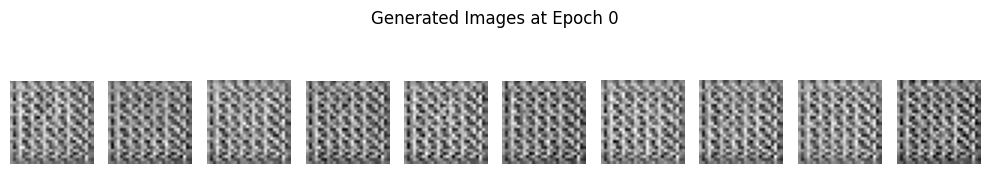

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

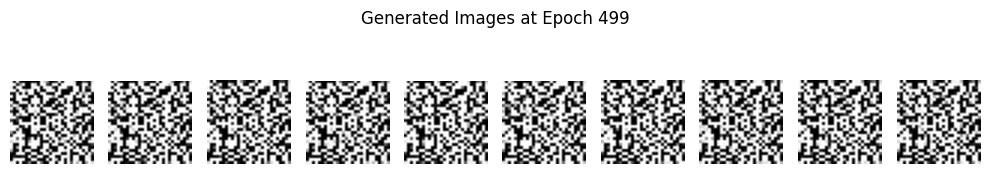

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


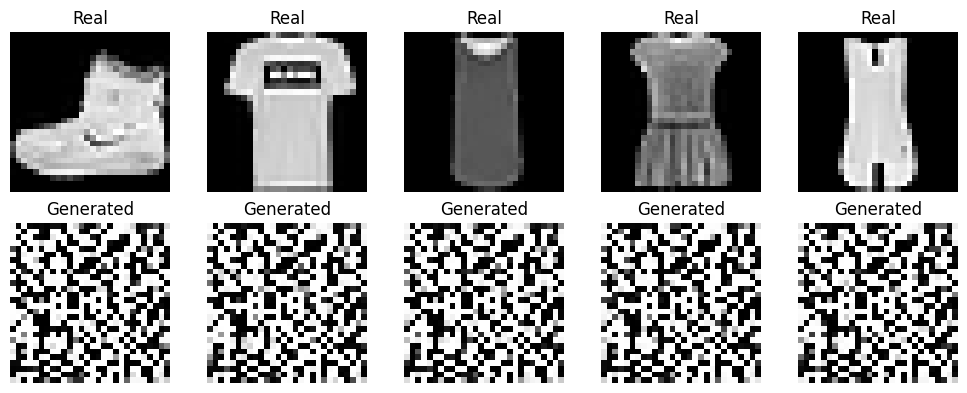

In [14]:
#Train the GAN and visualize progress
train_gan(generator, discriminator, gan, x_train, latent_dim=100, epochs=500, batch_size=64, save_interval=1000)

# Compare real and generated images
compare_real_and_generated(generator, x_train, latent_dim=100, num_images=5)